In [1]:
import sys
sys.path.insert(0, "..")
from utils.dataset_utils import OriginalDataset, plot_image_array, plot_delta

# Standard Downloads
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
original_dataset = OriginalDataset('../datasets/droid_100_sample_pictures')
len_ = (original_dataset.__len__())
print(len_)

166


Add No of subimages here: multiple of 2**n

In [3]:
image1 = original_dataset[0]
image1 = np.array(image1, dtype = np.int16)
image1.shape

# image2 = original_dataset[0]
# image2 = np.array(image1, dtype = np.int16)
# image2.shape


(180, 320, 3)

In [4]:
num_sub_img = 4

assert image1.shape[0]%num_sub_img == 0 , "choose another number of sub images"
assert image1.shape[1]%num_sub_img == 0 , " choose another number of sub images"

In [6]:
M = image1.shape[0]//num_sub_img
N = image1.shape[1]//num_sub_img
# M = N  16
print(M,N)

45 80


In [7]:
tiles1 = [image1[x:x+M,y:y+N] for x in range(0,image1.shape[0],M) for y in range(0,image1.shape[1],N)]
# tiles2 = [image2[x:x+M,y:y+N] for x in range(0,image2.shape[0],M) for y in range(0,image2.shape[1],N)]

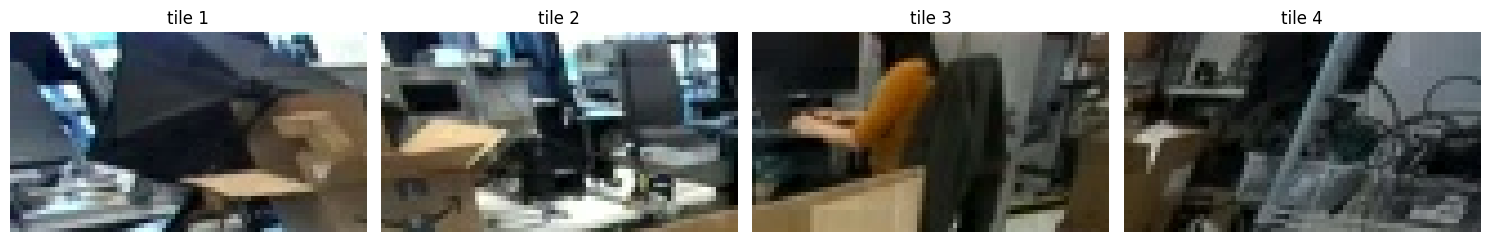

In [8]:
fig, axes = plt.subplots(1, num_sub_img, figsize=(15, 5))

for i in range (num_sub_img):
    axes[i].imshow(tiles1[i])
    axes[i].set_title(f'tile {i+1}')
    axes[i].axis('off')  # Turn off axis labels

# Show the plot
plt.tight_layout()
plt.show()



'SAVING IMAGE INTO NEW FOLDERS'

In [21]:
import os
from PIL import Image



# Dataset and output directories
output_base_path = "robotics_dataset_compression/datasets/sub_images"


# Create subfolders for each quadrant
folders = ["top_left", "top_right", "bottom_left", "bottom_right"]
for folder in folders:
    folder_path = os.path.join(output_base_path, folder)
    os.makedirs(folder_path, exist_ok=True)



# Process each image in the dataset
for idx in range(len(original_dataset)):  # Assuming you want to process the first 10 images
    image = original_dataset[idx]
    image = np.array(image)  # Convert image to numpy array

    # Get the center of the image
    height, width, _ = image.shape
    mid_height, mid_width = height // 2, width // 2

    # Split the image into four quadrants
    top_left = image[:mid_height, :mid_width]
    top_right = image[:mid_height, mid_width:]
    bottom_left = image[mid_height:, :mid_width]
    bottom_right = image[mid_height:, mid_width:]

    # Store the quadrants in a list
    quadrants = [top_left, top_right, bottom_left, bottom_right]

    # Save each quadrant to its corresponding folder
    for tile_idx, quadrant in enumerate(quadrants):
        # Determine the folder based on the index
        folder = folders[tile_idx]

        # Convert the quadrant to uint8 if necessary (ensure PIL can handle the data)
        quadrant = np.clip(quadrant, 0, 255).astype(np.uint8)  # Ensure the quadrant has values between 0 and 255

        # Convert the quadrant back to an image
        quadrant_image = Image.fromarray(quadrant)

        # Construct the save path
        save_path = os.path.join(output_base_path, folder, f"image_{idx}_tile_{tile_idx+1}.png")

        # Save the quadrant in PNG format
        quadrant_image.save(save_path, format="PNG")

print("Dataset processed and quadrants saved successfully!")


Dataset processed and quadrants saved successfully!


Converting into Videos

In [42]:
fps = 30
dataset_path = "robotics_dataset_compression/datasets/sub_images"
image_format = """idx_%d.png"""
out_dir = "robotics_dataset_compression/datasets/"

In [ ]:
import os

# Dataset and output directories
output_base_path = "robotics_dataset_compression/datasets/sub_images"
out_dir = "output_videos"  # Define the output directory
fps = 30  # Set frames per second
# Create subfolders for each quadrant
folders = ["top_left", "top_right", "bottom_left", "bottom_right"]

for i in folders:
    img_path = os.path.join(output_base_path, i)
    print(f"Processing folder: {img_path}")
    
    # Get list of images in the folder, sorted by file name to ensure correct sequence
    img_list = sorted([img for img in os.listdir(img_path) if img.endswith(".png")])

    # Calculate total size of images
    total_size = 0
    for img in img_list:
        img_full_path = os.path.join(img_path, img)  # Get the full path of the image
        total_size += os.path.getsize(img_full_path)
    
    print(f"Total size for {i}: {total_size} bytes")
    
    # Ensure output directory exists
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # Generate the sub-videos using ffmpeg with sorted images
    # Create the input pattern using sorted image file names
    input_pattern = os.path.join(img_path, "image_%d_tile_1.png")
    
    # Use ffmpeg to create videos
    os.system(f"ffmpeg -f image2 -framerate {fps} -i {input_pattern} -c:v libx264 -preset ultrafast -qp 0 {os.path.join(out_dir, f'{i}_output_lossless_h264_fast.mkv')}")
    os.system(f"ffmpeg -f image2 -framerate {fps} -i {input_pattern} -c:v libx264 -preset veryslow -qp 0 {os.path.join(out_dir, f'{i}_output_lossless_h264_slow.mkv')}")
    os.system(f"ffmpeg -f image2 -framerate {fps} -i {input_pattern} -c:v libx265 -preset ultrafast -x265-params lossless=1 {os.path.join(out_dir, f'{i}_output_lossless_h265_fast.mp4')}")
    os.system(f"ffmpeg -f image2 -framerate {fps} -i {input_pattern} -c:v libx265 -preset veryslow -x265-params lossless=1 {os.path.join(out_dir, f'{i}_output_lossless_h265_slow.mp4')}")
    
    # Get the size of the output video files
    h264_slow_size = os.path.getsize(os.path.join(out_dir, f"{i}_output_lossless_h264_slow.mkv"))
    h264_fast_size = os.path.getsize(os.path.join(out_dir, f"{i}_output_lossless_h264_fast.mkv"))
    h265_slow_size = os.path.getsize(os.path.join(out_dir, f"{i}_output_lossless_h265_slow.mp4"))
    h265_fast_size = os.path.getsize(os.path.join(out_dir, f"{i}_output_lossless_h265_fast.mp4"))
    
    print(f"{i} video sizes:")
    print(f"h264_slow_size: {h264_slow_size} bytes")
    print(f"h264_fast_size: {h264_fast_size} bytes")
    print(f"h265_slow_size: {h265_slow_size} bytes")
    print(f"h265_fast_size: {h265_fast_size} bytes")


Processing folder: robotics_dataset_compression/datasets/sub_images/top_left
Total size for top_left: 5166779 bytes
top_left video sizes:
h264_slow_size: 1993731 bytes
h264_fast_size: 2484462 bytes
h265_slow_size: 3175358 bytes
h265_fast_size: 3345642 bytes
Processing folder: robotics_dataset_compression/datasets/sub_images/top_right
Total size for top_right: 4816721 bytes


ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

FileNotFoundError: [Errno 2] No such file or directory: 'output_videos/top_right_output_lossless_h264_slow.mkv'

Recreating tiling Images

In [24]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Dataset and output directories
output_base_path = "robotics_dataset_compression/datasets/sub_images"
folders = ["top_left", "top_right", "bottom_left", "bottom_right"]

# Process each image in the dataset
for idx in range(10):  # Assuming you want to process the first 10 images
    # Get the image dimensions and create an empty list for quadrants
    original_image = original_dataset[idx]
    original_image = np.array(original_image)  # Convert image to numpy array
    height, width, _ = original_image.shape
    mid_height, mid_width = height // 2, width // 2

    # Load each quadrant from the corresponding folder
    quadrants = []
    for tile_idx, folder in enumerate(folders):
        # Construct the path for the quadrant
        save_path = os.path.join(output_base_path, folder, f"image_{idx}_tile_{tile_idx+1}.png")
        
        # Open the image and append it to the quadrants list
        quadrant_image = Image.open(save_path)
        quadrant_array = np.array(quadrant_image)
        quadrants.append(quadrant_array)

    # Reassemble the quadrants into a full image
    top_half = np.concatenate([quadrants[0], quadrants[1]], axis=1)  # Concatenate top-left and top-right
    bottom_half = np.concatenate([quadrants[2], quadrants[3]], axis=1)  # Concatenate bottom-left and bottom-right
    reassembled_image = np.concatenate([top_half, bottom_half], axis=0)  # Concatenate top and bottom

    # Compare the reassembled image with the original image
    if np.array_equal(original_image, reassembled_image):
        print(f"Image {idx} recreated successfully and matches the original.")
    else:
        print(f"Image {idx} recreated but does not match the original.")

    # Optionally, visualize the original and reassembled images for comparison
    # fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # axes[0].imshow(original_image)
    # axes[0].set_title('Original Image')
    # axes[0].axis('off')

    # axes[1].imshow(reassembled_image)
    # axes[1].set_title('Reassembled Image')
    # axes[1].axis('off')

    # plt.tight_layout()
    # plt.show()


Image 0 recreated successfully and matches the original.
Image 1 recreated successfully and matches the original.
Image 2 recreated successfully and matches the original.
Image 3 recreated successfully and matches the original.
Image 4 recreated successfully and matches the original.
Image 5 recreated successfully and matches the original.
Image 6 recreated successfully and matches the original.
Image 7 recreated successfully and matches the original.
Image 8 recreated successfully and matches the original.
Image 9 recreated successfully and matches the original.


recreating image

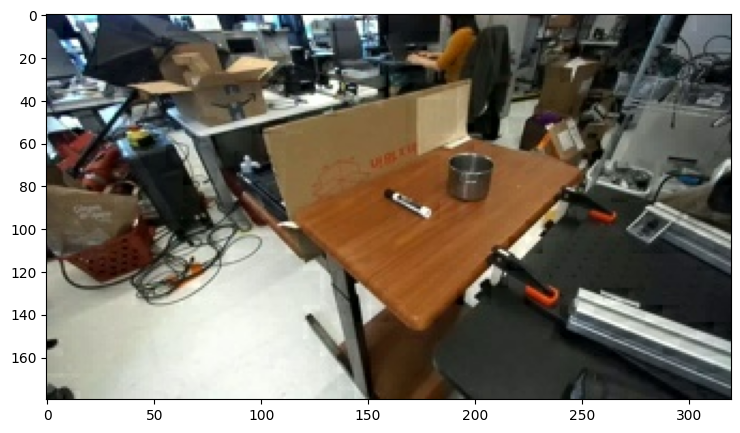

In [9]:

def recreate_image(tiles, original_shape, tile_size):
    # Create a blank image with the original shape
    reconstructed_image = np.zeros(original_shape, dtype=tiles[0].dtype)
    
    # Get the dimensions of each tile
    M, N = tile_size
    
    # Paste each tile back into the reconstructed image
    index = 0
    for x in range(0, original_shape[0], M):
        for y in range(0, original_shape[1], N):
            # Place the tile at the correct location
            reconstructed_image[x:x+M, y:y+N] = tiles[index]
            index += 1
    
    return reconstructed_image

# Example usage
# Assume tiles1 is your list of tiles, each tile has a size (M, N), and you know the original shape of the image
M, N = tiles1[0].shape[0], tiles1[0].shape[1]  # Size of each tile
original_shape = (M * (image1.shape[0] // M), N * (image1.shape[1] // N), image1.shape[2])  # Calculate original shape

# Recreate the image from the tiles
recreated_image = recreate_image(tiles1, original_shape, (M, N))


fig, axes = plt.subplots(1, 1, figsize=(15, 5))


plt.imshow(recreated_image)


plt.show()

In [10]:
diff = recreated_image - image1
non_zero_indices = np.nonzero(diff)
non_zero_indices


(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

*Start Patch Size*

In [14]:
patch_size = 4
sub_width = image1.shape[0]//patch_size # number of rows
sub_height = image1.shape[1]//patch_size # number of columns
# print(m,n)



In [19]:
grid_array = [ ]
for row in range(patch_size):
    row_images = []  
    for col in range(patch_size):
        sub_image = image1[row * sub_height : (row + 1) * sub_height, 
                                col * sub_width : (col + 1) * sub_width]
        row_images.append(grid_array)
    grid_array.append(row_images)
 
print(grid_array.size)


AttributeError: 'list' object has no attribute 'size'